In [ ]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import *
from sklearn import preprocessing
from IPython.display import display

## Load and preprocess single day df

In [ ]:
df = pd.read_csv('data/AIS_2024_01_01.csv')

# Preprocessing (ignore defaults from https://www.navcen.uscg.gov/ais-class-a-reports)
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
df = df.sort_values(by=['MMSI', 'BaseDateTime'])
df = df[df['COG'] != 360]
df = df[df['SOG'] != 102.3]
df = df[df['LAT'] != 181]
df = df[df['Heading'] != 511]
df = df.dropna()

# Get unique MMSIs
MMSIs = df['MMSI'].unique()
print(f"Number of unique MMSIs: {len(MMSIs)}")


In [9]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
22234,0,2024-01-01 00:01:59,36.91335,-76.18495,0.0,171.9,171.0,CG49420,NaN,NWHE,51.0,NaN,82.0,12.0,1.6,51.0,B
42146,0,2024-01-01 00:04:59,36.91334,-76.18494,0.0,176.7,176.0,CG49420,NaN,NWHE,51.0,NaN,82.0,12.0,1.6,51.0,B
30163,0,2024-01-01 00:07:59,36.91334,-76.18496,0.0,181.1,181.0,CG49420,NaN,NWHE,51.0,NaN,82.0,12.0,1.6,51.0,B
68416,0,2024-01-01 00:13:59,36.91335,-76.18495,0.0,178.1,178.0,CG49420,NaN,NWHE,51.0,NaN,82.0,12.0,1.6,51.0,B
74899,0,2024-01-01 00:16:59,36.91335,-76.18497,0.0,179.7,179.0,CG49420,NaN,NWHE,51.0,NaN,82.0,12.0,1.6,51.0,B


In [10]:
# Prints stats
print(f"Number of unique MMSIs: {len(MMSIs)}")
print(f"Total number of rows: {len(df)}")

Number of unique MMSIs: 5675
Total number of rows: 3348096


For each MMSI, compute the seconds since the start of the trajectory

In [18]:
# Dictionary to store MMSI stats
mmsi_stats = {}


for MMSI in tqdm(MMSIs, desc="Formatting dataset into trajectories"):
    single_ship_df = df[df['MMSI'] == MMSI]
    single_ship_df = single_ship_df.sort_values(by='BaseDateTime')
    single_ship_df = single_ship_df.drop_duplicates(subset=['BaseDateTime'], keep='last')
    
    # Compute seconds since start
    earliest_time = single_ship_df['BaseDateTime'].min()
    single_ship_df.head()
    single_ship_df['SecondsSinceStart'] = (single_ship_df['BaseDateTime'] - earliest_time).dt.total_seconds()
    df.loc[single_ship_df.index, 'SecondsSinceStart'] = single_ship_df['SecondsSinceStart']

    # Apply StandardScaler on LON, LAT, and Heading
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(single_ship_df[['LON', 'LAT', 'Heading']])
    df.loc[single_ship_df.index, ['Scaled_LON', 'Scaled_LAT', 'Scaled_Heading']] = scaled_features

    # Store mmsi stats
    mmsi_stats[MMSI] = {
        'EarliestTime': earliest_time,
        'LastTime': single_ship_df['BaseDateTime'].max(),
        'TotalDuration': (single_ship_df['BaseDateTime'].max() - earliest_time).total_seconds(),
        'NumRecords': len(single_ship_df),
    }

single_ship_df.head()


Formatting dataset into trajectories: 100%|██████████| 5675/5675 [00:26<00:00, 217.01it/s]


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,SecondsSinceStart,Scaled_LON,Scaled_LAT,Scaled_Heading
40014,987654321,2024-01-01 00:04:30,48.42099,-123.38656,0.0,351.7,322.0,VIEW,NaN,NaN,...,5.0,0.0,0.0,0.0,60.0,A,0.0,NaN,NaN,NaN
54804,987654321,2024-01-01 00:10:30,48.42099,-123.38656,0.0,268.6,321.0,VIEW,NaN,NaN,...,5.0,0.0,0.0,0.0,99.0,A,360.0,NaN,NaN,NaN
74294,987654321,2024-01-01 00:16:29,48.42099,-123.38656,0.0,125.6,323.0,VIEW,NaN,NaN,...,5.0,0.0,0.0,0.0,99.0,A,719.0,NaN,NaN,NaN
104907,987654321,2024-01-01 00:22:31,48.42099,-123.38656,0.0,113.1,322.0,VIEW,NaN,NaN,...,5.0,0.0,0.0,0.0,99.0,A,1081.0,NaN,NaN,NaN
129333,987654321,2024-01-01 00:28:30,48.42099,-123.38656,0.0,181.9,322.0,VIEW,NaN,NaN,...,5.0,0.0,0.0,0.0,99.0,A,1440.0,NaN,NaN,NaN


In [12]:
# Find the MMSI with the second most records
mmsi_stats
sorted_mmsi_stats = sorted(mmsi_stats.items(), key=lambda x: x[1]['NumRecords'], reverse=True)
# max_records_mmsi = max(mmsi_stats, key=lambda k: mmsi_stats[k]['NumRecords'])
# max_records_mmsi
sorted_mmsi_stats[0]

(np.int64(366921510),
 {'EarliestTime': Timestamp('2024-01-01 00:00:00'),
  'LastTime': Timestamp('2024-01-01 23:59:09'),
  'TotalDuration': 86349.0,
  'NumRecords': 1386})

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,TransceiverClass,SecondsSinceStart,Scaled_LON,Scaled_LAT,Scaled_Heading
7266139,368145530,2024-01-01 23:32:07,28.76115,-94.14226,1.6,3.5,12.0,ANNABELLE MILLER,IMO9575113,WDL5902,...,0.0,54.0,14.0,3.3,90.0,A,66469.0,1.405839,0.597091,-1.126187
6275106,368145530,2024-01-01 23:34:16,28.76194,-94.14217,0.8,353.0,15.0,ANNABELLE MILLER,IMO9575113,WDL5902,...,0.0,54.0,14.0,3.3,90.0,A,66598.0,1.411434,0.610800,-1.080812
6312825,368145530,2024-01-01 23:36:48,28.76238,-94.14233,0.6,259.0,18.0,ANNABELLE MILLER,IMO9575113,WDL5902,...,0.0,54.0,14.0,3.3,90.0,A,66750.0,1.401487,0.618436,-1.035438
6548759,368145530,2024-01-01 23:41:27,28.76197,-94.14322,0.4,306.5,19.0,ANNABELLE MILLER,IMO9575113,WDL5902,...,0.0,54.0,14.0,3.3,90.0,A,67029.0,1.346152,0.611321,-1.020313
7282872,368145530,2024-01-01 23:57:17,28.76046,-94.14793,8.8,140.5,135.0,ANNABELLE MILLER,IMO9575113,WDL5902,...,0.0,54.0,14.0,3.3,90.0,A,67979.0,1.053316,0.585116,0.734167


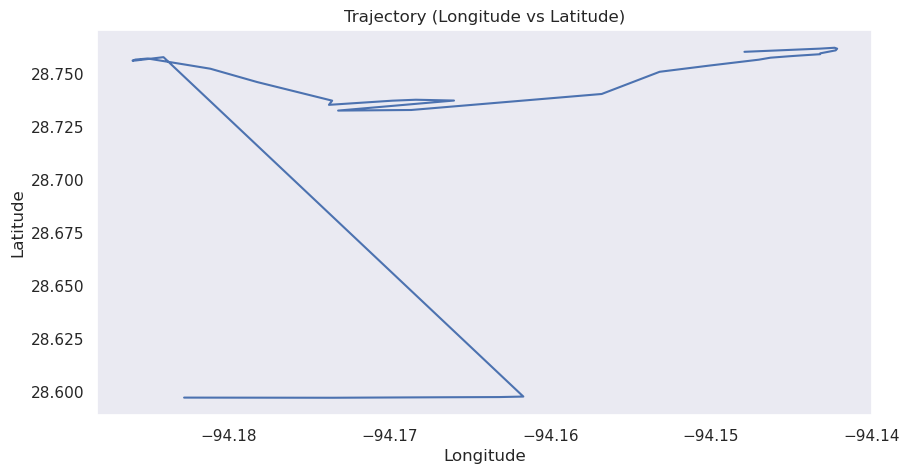

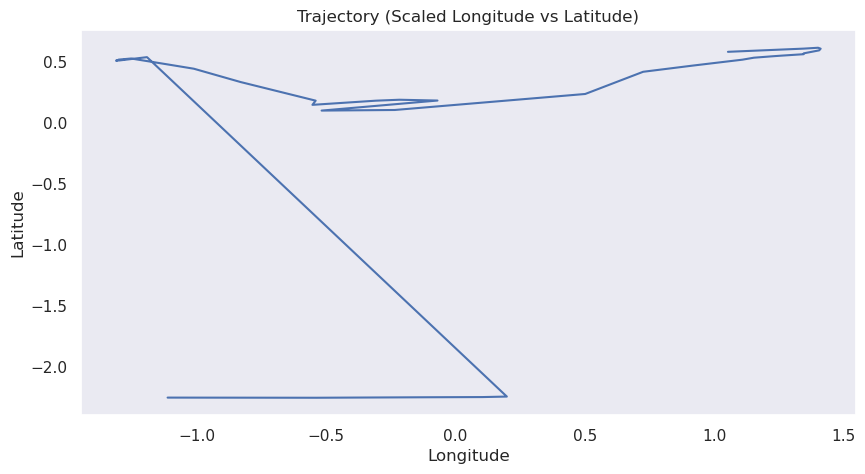

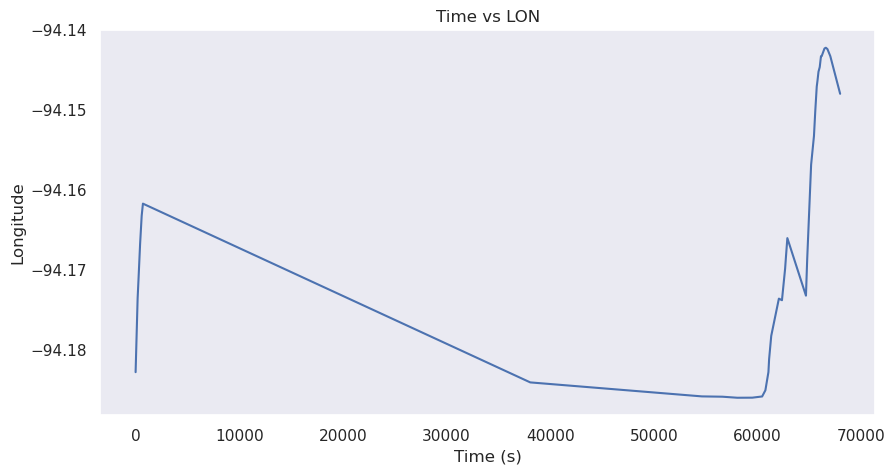

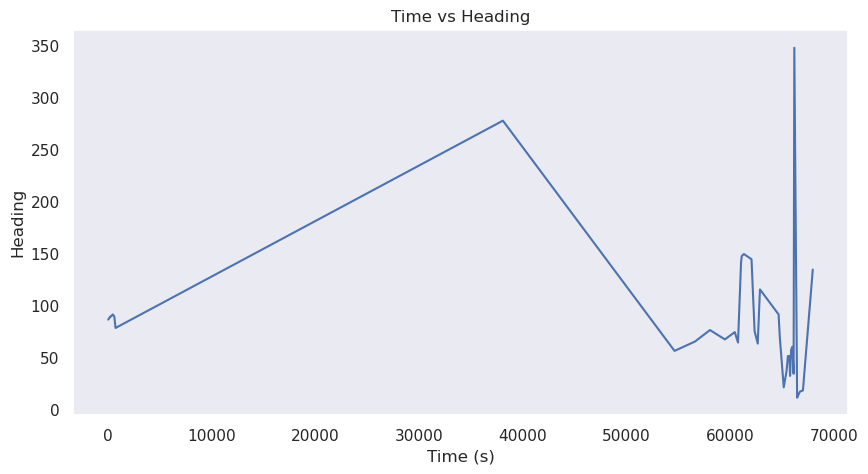

In [87]:
single_ship_df = df[df['MMSI'] == sorted_mmsi_stats[5000][0]]
# single_ship_df = single_ship_df.dropna()
display(single_ship_df.tail())



# Plot Longitude vs Latitude
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['LON'], single_ship_df['LAT'], label='Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory (Longitude vs Latitude)')
plt.grid()
plt.show()

# Plot Scaled Longitude vs Latitude
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['Scaled_LON'], single_ship_df['Scaled_LAT'], label='Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectory (Scaled Longitude vs Latitude)')
plt.grid()
plt.show()

# Plot Time vs LON
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['LON'])
plt.xlabel('Time (s)')
plt.ylabel('Longitude')
plt.title('Time vs LON')
plt.grid()
plt.show()

# Plot Time vs Heading
plt.figure(figsize=(10, 5))
plt.plot(single_ship_df['SecondsSinceStart'], single_ship_df['Heading'])
plt.xlabel('Time (s)')
plt.ylabel('Heading')
plt.title('Time vs Heading')
plt.grid()
plt.show()


In [88]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
import time
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gp = GaussianProcessRegressor(kernel=kernel)


# GP fit
start_time = time.time()
gp.fit(single_ship_df[['SecondsSinceStart']], single_ship_df[['Scaled_LON']])
print(f"GP fit time: {time.time() - start_time:.2f} seconds")
print(f"GP kernel: {gp.kernel_}")


# GRP predict
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gp.predict(single_ship_df[['SecondsSinceStart']], return_std=True)
print(f"GP predict time: {time.time() - start_time:.2f} seconds")

GP fit time: 0.01 seconds
GP kernel: RBF(length_scale=1) + WhiteKernel(noise_level=0.000696)
GP predict time: 0.00 seconds


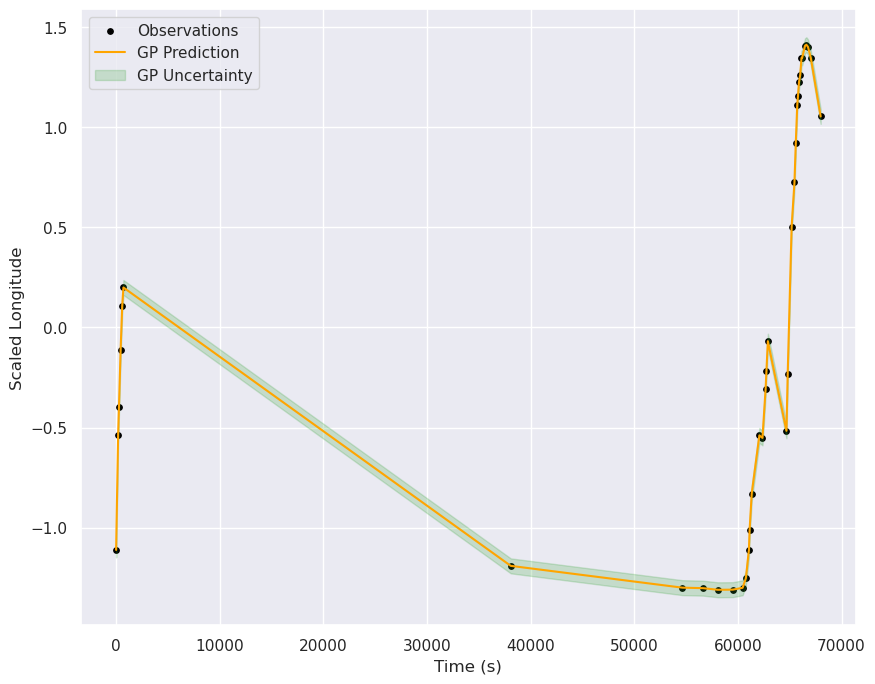

In [89]:
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(10, 8))
plt.scatter(single_ship_df['SecondsSinceStart'], single_ship_df['Scaled_LON'], s=15, color="black", label='Observations')

# Plot GPR preditions
plt.plot(single_ship_df['SecondsSinceStart'], gp.predict(single_ship_df[['SecondsSinceStart']]), color="orange", label='GP Prediction')

plt.fill_between(single_ship_df['SecondsSinceStart'], mean_predictions_gpr - std_predictions_gpr, mean_predictions_gpr + std_predictions_gpr, alpha=0.2, color="tab:green", label='GP Uncertainty')

plt.xlabel("Time (s)")
plt.ylabel("Scaled Longitude")
plt.legend()


